 - https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
 - https://github.com/alexvlis/extractive-document-summarization

In [1]:
from rouge import Rouge
import os
from nltk import tokenize

In [2]:
import gensim
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
import nltk

Using TensorFlow backend.


In [3]:
rouge = Rouge()

In [4]:
import numpy as np
import pandas as pd
import pickle
import sys
import warnings
warnings.filterwarnings("ignore")

### Data load forCNN/Dailymail  Dataset.

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
data, info = tfds.load(name="cnn_dailymail", with_info=True)
print(data.keys())

dict_keys(['test', 'train', 'validation'])


In [6]:
# take 900 Documents
x =pd.DataFrame(data['train'])
Data = pd.DataFrame(x[0:900])

In [7]:
# Extract text and summary

# convert tensor to string

t = []
for i in Data.article:
    i = (i.numpy().decode("utf-8") )
    i = tokenize.sent_tokenize(i)
    t.append(i)
    
s = []
for i in Data.highlights:
    i = (i.numpy().decode("utf-8") )
    i = tokenize.sent_tokenize(i)
    s.append(i)

Data['article'] = t
Data['highlights'] = s

totalSentences = sum([len(i)for i in Data.article])
totalSentences

34868

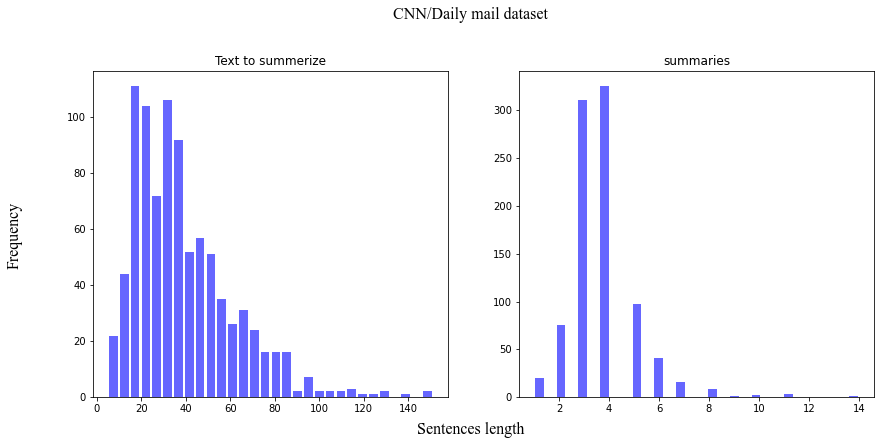

In [8]:
sentences_doc = [len(i)for i in Data.article]
#print(sentences_doc)
summary_doc = [len(i)for i in Data.highlights]

fig = plt.figure(figsize=(14,6)) # Create matplotlib figure
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical',fontname = 'Times New Roman',fontsize = 16)
fig.text(0.5, 0.04, 'Sentences length', ha='center',fontname = 'Times New Roman',fontsize = 16)
fig.text(0.5, 1, 'CNN/Daily mail dataset', ha='center',fontname = 'Times New Roman',fontsize = 16)
ax = fig.add_subplot(121) # Create matplotlib axes
ax2 = fig.add_subplot(122) # Create another axes that shares the same x-axis as ax.

ax.hist(sentences_doc,bins = 30,color="blue", alpha = 0.6,rwidth= 0.8)
ax.set_title("Text to summerize", fontsize=12)

ax2.hist(summary_doc,bins = 30,color="blue", alpha = 0.6,rwidth= 0.8)
ax2.set_title("summaries", fontsize=12)

plt.show()

In [9]:
# total numner of sentences in text 
totalSentences = sum([len(i)for i in Data.article])
totalSentences

34868

In [10]:
Data.reset_index(level=0, inplace=True)

In [11]:
# obtain the salience score for the response variable.

alpha = 0.8
cind = 0
dt_smry_score = np.zeros((totalSentences, 3), dtype=object)
for i,j in enumerate(Data.article):
    sentences =j
    summary = Data.highlights[i]
    summary = " ".join (Data.highlights[i])

    for s in sentences:
        dt_smry_score [cind, 0] = Data.index[i]
        dt_smry_score [cind, 1] = s
        try:
            R1 = rouge.get_scores(s, summary)[0]['rouge-1']['f']
            R2 = rouge.get_scores(s, summary)[0]['rouge-2']['f']
            dt_smry_score [cind, 2] = alpha * R1 + (1 - alpha) * R2

        except:
            dt_smry_score [cind, 2] = -1
        cind = cind+1

In [12]:
dt_smry_score[:,1][0]

'By .'

In [13]:
sentences = dt_smry_score[:,1]
#Load Google pre-trained words 
embedding_model = gensim.models.KeyedVectors.load_word2vec_format(
    'C:/Users/amitp/Downloads/extractive-document-summarization-master/word2vec/GoogleNews-vectors-negative300.bin.gz', 
    binary=True, 
    limit=50000)


In [14]:
word_vectors = embedding_model.wv
max_sen_len = 250
#tokenize sentences
tokenizer = Tokenizer(num_words=30000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) # replace words with its wordid
padded_sequences = pad_sequences(sequences,maxlen=max_sen_len)
word_index = tokenizer.word_index
# word embedding with 300 dimensions
embedding_weights = {key: embedding_model[word] if word in word_vectors.vocab else
                              np.random.uniform(-0.25, 0.25, word_vectors.vector_size)
                        for word, key in word_index.items()}

In [15]:
embedding_weights[0] = np.zeros(word_vectors.vector_size)
#Build a 3D array: 1D fnumber of sentences, 1D for the no of words and 1D for word embedding. 
embedded_sentences = np.stack([np.stack([embedding_weights[t] for t in s]) for s in padded_sequences])


In [17]:
input_output = np.array([]) # data + rouge score
for i in range(len(data)):
    input_output = np.append(input_output,np.array([ embedded_sentences[i] , dt_smry_score[i,2] ]) )

In [ ]:
embedded_sentences.shape,len(data[:,2])

In [ ]:
embedded_sentences[4].shape

In [ ]:
# split embedded data into multiple files and save it.
num_parts = 8
fileName = "Embedding_saliency"
start = 0

for i in range(num_parts):
    print("writing part,",i + 1)
    f = open(fileName + str(i + 1) + ".pickle", "wb")
    if i < num_parts - 1:
        pickle.dump(input_output[start:(i + 1) * len(input_output)//num_parts], f)
    else:
        pickle.dump(input_output[start:], f)
    f.close()
    start = (i + 1) * len(input_output)//num_parts
    print(start)